# 1. Import Libraries

In [2]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

# 2. Display Setttings

In [3]:
pd.set_option("display.max_columns",None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

# 3. Reading Data

In [4]:
path = r"C:\Users\msved\OneDrive\Documents\Campus X\FLIGHT PREDICTION USING AWS SAGEMAKER\data\train.csv"
train =pd.read_csv(path)
train

,date_of_journey,airlines,airlines_code,class,departure,total_stops,arrival,duration_in_minutes,source,destination,price_fare
0,2024-04-01,Vistara,UK-855,Premium Economy,00:26:00,1.0,07:27:00,334.8,Delhi,Cochin,23238
1,2024-03-26,Air India,AI-443,Economy,12:19:00,1.0,05:17:00,304.8,Kolkata,Banglore,8516
2,2024-12-09,Air India,AI-815,Business,10:46:00,1.0,18:57:00,355.2,Delhi,Cochin,53164
3,2024-09-08,Go First,G8-2519,Economy,21:06:00,0.0,13:02:00,850.2,Banglore,Delhi,6873
4,2024-05-04,Vistara,UK-929,Business,18:15:00,1.0,02:34:00,535.2,Kolkata,Banglore,22297
...,...,...,...,...,...,...,...,...,...,...,...
6831,2024-08-05,Vistara,UK-969,Business,00:44:00,0.0,17:15:00,1485.0,Banglore,Delhi,30249
6832,2024-07-27,Vistara,UK-995,Business,21:39:00,1.0,09:48:00,135.0,Delhi,Cochin,41528
6833,2024-08-14,Air India,AI-887,Business,09:21:00,0.0,07:38:00,135.0,Banglore,Delhi,25612
6834,2024-02-21,Indigo,6E-6475,Economy,07:53:00,1.0,17:31:00,589.8,Delhi,Cochin,6672


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6836 entries, 0 to 6835
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_of_journey      6836 non-null   object 
 1   airlines             6836 non-null   object 
 2   airlines_code        6836 non-null   object 
 3   class                6836 non-null   object 
 4   departure            6836 non-null   object 
 5   total_stops          6836 non-null   float64
 6   arrival              6836 non-null   object 
 7   duration_in_minutes  6836 non-null   float64
 8   source               6836 non-null   object 
 9   destination          6836 non-null   object 
 10  price_fare           6836 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 587.6+ KB


In [6]:
X_train = train.drop(columns="price_fare")
y_train = train.price_fare.copy()

# 4. Transformation Operations

## 4.1 Airlines

In [7]:
X_train.airlines

0         Vistara
1       Air India
2       Air India
3        Go First
4         Vistara
          ...    
6831      Vistara
6832      Vistara
6833    Air India
6834       Indigo
6835    Air India
Name: airlines, Length: 6836, dtype: object

In [8]:
airline_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("grouper",RareLabelEncoder(tol = 0.1,replace_with="Other",n_categories=2)),
        ("encoder",OneHotEncoder(sparse_output=False,handle_unknown = "ignore"))
    ]
)
airline_transformer.fit_transform(X_train.loc[:,["airlines"]])#.airlines.value_counts()

,airlines_Air India,airlines_Indigo,airlines_Other,airlines_Vistara
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
6831,0.0,0.0,0.0,1.0
6832,0.0,0.0,0.0,1.0
6833,1.0,0.0,0.0,0.0
6834,0.0,1.0,0.0,0.0


## 4.2 Date of Journey

In [9]:
X_train.date_of_journey

0       2024-04-01
1       2024-03-26
2       2024-12-09
3       2024-09-08
4       2024-05-04
           ...    
6831    2024-08-05
6832    2024-07-27
6833    2024-08-14
6834    2024-02-21
6835    2024-10-27
Name: date_of_journey, Length: 6836, dtype: object

In [10]:
feature_to_fetch = ["month","week","day_of_week","day_of_year"]
doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_fetch, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.272727,0.254902,0.000000,0.249315
1,0.181818,0.235294,0.166667,0.232877
2,1.000000,0.960784,0.000000,0.939726
3,0.727273,0.686275,1.000000,0.687671
4,0.363636,0.333333,0.833333,0.339726
...,...,...,...,...
6831,0.636364,0.607843,0.000000,0.594521
6832,0.545455,0.568627,0.833333,0.569863
6833,0.636364,0.627451,0.333333,0.619178
6834,0.090909,0.137255,0.333333,0.139726


## 4.3. Source and Destination

In [14]:
# checking source columns
X_train.source

0          Delhi
1        Kolkata
2          Delhi
3       Banglore
4        Kolkata
          ...   
6831    Banglore
6832       Delhi
6833    Banglore
6834       Delhi
6835       Delhi
Name: source, Length: 6836, dtype: object

In [15]:
# checking destination column
X_train.destination

0         Cochin
1       Banglore
2         Cochin
3          Delhi
4       Banglore
          ...   
6831       Delhi
6832      Cochin
6833       Delhi
6834      Cochin
6835      Cochin
Name: destination, Length: 6836, dtype: object

In [16]:
# it will take only source and destination as column in location_subpart
location_subpart = X_train.loc[:,["source","destination"]]
location_subpart

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Banglore,Delhi
4,Kolkata,Banglore
...,...,...
6831,Banglore,Delhi
6832,Delhi,Cochin
6833,Banglore,Delhi
6834,Delhi,Cochin


In [26]:
# grouper function will group all the columns whose tolerance level is less than 0.1 and combine into 1
# encoder will take mean value of that particular group. This mean encoder gives us the large values.
# Therefore, we will need Power transformer to smaller that value and it comes in the range of [-1,1].

location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subpart, y_train)

,source,destination
0,-1.831868e-15,-2.053913e-15
1,2.831069e-15,3.275158e-15
2,-1.831868e-15,-2.053913e-15
3,1.443290e-15,-3.441691e-15
4,2.831069e-15,3.275158e-15
...,...,...
6831,1.443290e-15,-3.441691e-15
6832,-1.831868e-15,-2.053913e-15
6833,1.443290e-15,-3.441691e-15
6834,-1.831868e-15,-2.053913e-15


In [27]:
# union of two arrays
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [29]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Cochin","Delhi","New Delhi"]
    return (
        X
        .assign(**{
f"{col}_is_north": X.loc[:,col].isin(north_cities).astype(int)
for col in columns

        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subpart)

,source_is_north,destination_is_north
0,1,1
1,0,0
2,1,1
3,0,1
4,0,0
...,...,...
6831,0,1
6832,1,1
6833,0,1
6834,1,1


In [31]:
# combining part 1 and 2 for faster execution
location_transformer = FeatureUnion(
    transformer_list=[
("part1",location_pipe1),
("part2",FunctionTransformer(func=is_north))

    ]
)
location_transformer.fit_transform(location_subpart,y_train)

,source,destination,source_is_north,destination_is_north
0,-1.831868e-15,-2.053913e-15,1,1
1,2.831069e-15,3.275158e-15,0,0
2,-1.831868e-15,-2.053913e-15,1,1
3,1.443290e-15,-3.441691e-15,0,1
4,2.831069e-15,3.275158e-15,0,0
...,...,...,...,...
6831,1.443290e-15,-3.441691e-15,0,1
6832,-1.831868e-15,-2.053913e-15,1,1
6833,1.443290e-15,-3.441691e-15,0,1
6834,-1.831868e-15,-2.053913e-15,1,1


## 4.4 Departure and Arrival time

In [36]:
X_train.departure

0       00:26:00
1       12:19:00
2       10:46:00
3       21:06:00
4       18:15:00
          ...   
6831    00:44:00
6832    21:39:00
6833    09:21:00
6834    07:53:00
6835    01:36:00
Name: departure, Length: 6836, dtype: object

In [37]:
X_train.arrival

0       07:27:00
1       05:17:00
2       18:57:00
3       13:02:00
4       02:34:00
          ...   
6831    17:15:00
6832    09:48:00
6833    07:38:00
6834    17:31:00
6835    20:35:00
Name: arrival, Length: 6836, dtype: object

In [39]:
time_subpart = X_train.loc[:,["departure","arrival"]]
time_subpart

,departure,arrival
0,00:26:00,07:27:00
1,12:19:00,05:17:00
2,10:46:00,18:57:00
3,21:06:00,13:02:00
4,18:15:00,02:34:00
...,...,...
6831,00:44:00,17:15:00
6832,21:39:00,09:48:00
6833,09:21:00,07:38:00
6834,07:53:00,17:31:00


In [41]:
time_pipe1 = Pipeline(
    steps=[
        ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
        ("scaler",MinMaxScaler())
    ]
)
time_pipe1.fit_transform(time_subpart)

,departure_hour,departure_minute,arrival_hour,arrival_minute
0,0.000000,0.440678,0.304348,0.457627
1,0.521739,0.322034,0.217391,0.288136
2,0.434783,0.779661,0.782609,0.966102
3,0.913043,0.101695,0.565217,0.033898
4,0.782609,0.254237,0.086957,0.576271
...,...,...,...,...
6831,0.000000,0.745763,0.739130,0.254237
6832,0.913043,0.661017,0.391304,0.813559
6833,0.391304,0.355932,0.304348,0.644068
6834,0.304348,0.898305,0.739130,0.525424


In [43]:
# this function will help us to get extra info regarding morning, noon, evening or night time 
def part_of_day(X,morning=4,noon=12,evening=16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(
        **{
            col : pd.to_datetime(X.loc[:,col]).dt.hour 
            for col in columns
        }
    )

    return (
        X_temp
        .assign(
            **{
                f"{col}_part_of_day":np.select(
                    [ # used to filter the day or night time 
                        X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                        X_temp.loc[:, col].between(noon, evening, inclusive="left"),
				         X_temp.loc[:, col].between(evening, night, inclusive="left")],
				        ["morning", "afternoon", "evening"],
				        default="night"

                    
                ) for col in columns
            }
        ).drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subpart)

,departure_part_of_day,arrival_part_of_day
0,night,morning
1,afternoon,morning
2,morning,evening
3,night,afternoon
4,evening,night
...,...,...
6831,night,evening
6832,night,morning
6833,morning,morning
6834,morning,evening


In [46]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()), # it labels with the counting of total morning in morning labels,
    #   and does similarly for other part of the day as well.
	("scaler", MinMaxScaler()) # convert number between [0,1].
])

time_pipe2.fit_transform(time_subpart)

,departure_part_of_day,arrival_part_of_day
0,1.000000,0.957447
1,0.038804,0.957447
2,0.991916,0.000000
3,1.000000,0.000000
4,0.000000,1.000000
...,...,...
6831,1.000000,0.000000
6832,1.000000,0.957447
6833,0.991916,0.957447
6834,0.991916,0.000000


In [49]:
time_transformer = FeatureUnion(
    transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(time_subpart)

,departure_hour,departure_minute,arrival_hour,arrival_minute,departure_part_of_day,arrival_part_of_day
0,0.000000,0.440678,0.304348,0.457627,1.000000,0.957447
1,0.521739,0.322034,0.217391,0.288136,0.038804,0.957447
2,0.434783,0.779661,0.782609,0.966102,0.991916,0.000000
3,0.913043,0.101695,0.565217,0.033898,1.000000,0.000000
4,0.782609,0.254237,0.086957,0.576271,0.000000,1.000000
...,...,...,...,...,...,...
6831,0.000000,0.745763,0.739130,0.254237,1.000000,0.000000
6832,0.913043,0.661017,0.391304,0.813559,1.000000,0.957447
6833,0.391304,0.355932,0.304348,0.644068,0.991916,0.957447
6834,0.304348,0.898305,0.739130,0.525424,0.991916,0.000000


## 4.5 Duration

In [71]:
X_train.duration_in_minutes

0        334.8
1        304.8
2        355.2
3        850.2
4        535.2
         ...  
6831    1485.0
6832     135.0
6833     135.0
6834     589.8
6835     145.2
Name: duration_in_minutes, Length: 6836, dtype: float64

In [72]:
(
	X_train
	.duration_in_minutes
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1) # -1 means all rows, and 1 means single column. This is used to change the shape of an array
	# .shape
)

array([[289.8],
       [505.2],
       [865.2]])

In [73]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [74]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)


,total_stops_rbf_40,total_stops_rbf_80,duration_in_minutes_rbf_40,duration_in_minutes_rbf_80
0,1.000000,1.000000,4.663738e-133,0.0
1,1.000000,1.000000,5.544960e-316,0.0
2,1.000000,1.000000,2.542149e-53,0.0
3,0.904837,0.904837,0.000000e+00,0.0
4,1.000000,1.000000,0.000000e+00,0.0
...,...,...,...,...
6831,0.904837,0.904837,0.000000e+00,0.0
6832,1.000000,1.000000,0.000000e+00,0.0
6833,0.904837,0.904837,0.000000e+00,0.0
6834,1.000000,1.000000,0.000000e+00,0.0


In [79]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration_in_minutes.lt(short),
									    X.duration_in_minutes.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration_in_minutes")
	)

In [80]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration_in_minutes.ge(value).astype(int)
		})
		.drop(columns="duration_in_minutes")
	)

In [81]:

duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration_in_minutes"]])

,duration_in_minutes_rbf_25,duration_in_minutes_rbf_50,duration_in_minutes_rbf_75,duration_cat,duration_over_1000,duration_in_minutes
0,-0.139861,-0.127673,-0.134773,1.0,0,-0.653434
1,-0.139861,-0.127673,-0.134773,1.0,0,-0.725346
2,-0.139861,-0.127673,-0.134773,1.0,0,-0.604534
3,-0.139861,-0.127673,-0.134773,2.0,0,0.582011
4,-0.139861,-0.127673,-0.134773,2.0,0,-0.173063
...,...,...,...,...,...,...
6831,-0.139861,-0.127673,-0.134773,2.0,1,2.103664
6832,-0.139861,-0.127673,-0.134773,0.0,0,-1.132366
6833,-0.139861,-0.127673,-0.134773,0.0,0,-1.132366
6834,-0.139861,-0.127673,-0.134773,2.0,0,-0.042184


## 4.6. Total Stops

In [87]:
X_train.total_stops

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
6831    0.0
6832    1.0
6833    0.0
6834    1.0
6835    2.0
Name: total_stops, Length: 6836, dtype: float64

In [90]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

'''The SimpleImputer is used to fill in missing values in the X_train DataFrame. 
With strategy="most_frequent",it replaces missing values with the most frequently occurring value in each column.'''

total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,1.0,0
3,0.0,1
4,1.0,0
...,...,...
6831,0.0,1
6832,1.0,0
6833,0.0,1
6834,1.0,0


# 4.8 Column Transformer

In [91]:
column_transform = ColumnTransformer(transformers=[
("air",airline_transformer,["airlines"]),
("doj",doj_transformer,["date_of_journey"]),
("location",location_transformer,["source","destination"]),
("time",time_transformer,["departure","arrival"]),
("dur", duration_transformer, ["duration_in_minutes"]),
("stops", total_stops_transformer, ["total_stops"]),

])

In [92]:
column_transform.fit_transform(X_train,y_train)

,air__airlines_Air India,air__airlines_Indigo,air__airlines_Other,air__airlines_Vistara,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__departure_hour,time__departure_minute,time__arrival_hour,time__arrival_minute,time__departure_part_of_day,time__arrival_part_of_day,dur__duration_in_minutes_rbf_25,dur__duration_in_minutes_rbf_50,dur__duration_in_minutes_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration_in_minutes,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.0,1.0,0.272727,0.254902,0.000000,0.249315,-1.831868e-15,-2.053913e-15,1,1,0.000000,0.440678,0.304348,0.457627,1.000000,0.957447,-0.139861,-0.127673,-0.134773,1.0,0,-0.653434,1.0,0
1,1.0,0.0,0.0,0.0,0.181818,0.235294,0.166667,0.232877,2.831069e-15,3.275158e-15,0,0,0.521739,0.322034,0.217391,0.288136,0.038804,0.957447,-0.139861,-0.127673,-0.134773,1.0,0,-0.725346,1.0,0
2,1.0,0.0,0.0,0.0,1.000000,0.960784,0.000000,0.939726,-1.831868e-15,-2.053913e-15,1,1,0.434783,0.779661,0.782609,0.966102,0.991916,0.000000,-0.139861,-0.127673,-0.134773,1.0,0,-0.604534,1.0,0
3,0.0,0.0,1.0,0.0,0.727273,0.686275,1.000000,0.687671,1.443290e-15,-3.441691e-15,0,1,0.913043,0.101695,0.565217,0.033898,1.000000,0.000000,-0.139861,-0.127673,-0.134773,2.0,0,0.582011,0.0,1
4,0.0,0.0,0.0,1.0,0.363636,0.333333,0.833333,0.339726,2.831069e-15,3.275158e-15,0,0,0.782609,0.254237,0.086957,0.576271,0.000000,1.000000,-0.139861,-0.127673,-0.134773,2.0,0,-0.173063,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,0.0,0.0,0.0,1.0,0.636364,0.607843,0.000000,0.594521,1.443290e-15,-3.441691e-15,0,1,0.000000,0.745763,0.739130,0.254237,1.000000,0.000000,-0.139861,-0.127673,-0.134773,2.0,1,2.103664,0.0,1
6832,0.0,0.0,0.0,1.0,0.545455,0.568627,0.833333,0.569863,-1.831868e-15,-2.053913e-15,1,1,0.913043,0.661017,0.391304,0.813559,1.000000,0.957447,-0.139861,-0.127673,-0.134773,0.0,0,-1.132366,1.0,0
6833,1.0,0.0,0.0,0.0,0.636364,0.627451,0.333333,0.619178,1.443290e-15,-3.441691e-15,0,1,0.391304,0.355932,0.304348,0.644068,0.991916,0.957447,-0.139861,-0.127673,-0.134773,0.0,0,-1.132366,0.0,1
6834,0.0,1.0,0.0,0.0,0.090909,0.137255,0.333333,0.139726,-1.831868e-15,-2.053913e-15,1,1,0.304348,0.898305,0.739130,0.525424,0.991916,0.000000,-0.139861,-0.127673,-0.134773,2.0,0,-0.042184,1.0,0


## 5. Feature Selection


In [99]:
''' This example demonstrates how to integrate custom transformers and 
feature selection into a single scikit-learn pipeline.
 The SelectBySingleFeaturePerformance selects features based on their individual performance with a RandomForestRegressor, which is then used for the final modeling step. This approach ensures that the entire process is streamlined and can be evaluated using cross-validation or other model evaluation techniques.

'''
estimator = RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.0005 # minimum r2 score required to select the columns.
)

## 6. Putting it all Together


In [100]:
preprocessor = Pipeline(steps=[
	("ct", column_transform),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airlines_Air India,air__airlines_Indigo,air__airlines_Other,air__airlines_Vistara,dur__duration_in_minutes_rbf_25,dur__duration_in_minutes_rbf_50,dur__duration_cat,dur__duration_over_1000,dur__duration_in_minutes
0,0.0,0.0,0.0,1.0,-0.139861,-0.127673,1.0,0,-0.653434
1,1.0,0.0,0.0,0.0,-0.139861,-0.127673,1.0,0,-0.725346
2,1.0,0.0,0.0,0.0,-0.139861,-0.127673,1.0,0,-0.604534
3,0.0,0.0,1.0,0.0,-0.139861,-0.127673,2.0,0,0.582011
4,0.0,0.0,0.0,1.0,-0.139861,-0.127673,2.0,0,-0.173063
...,...,...,...,...,...,...,...,...,...
6831,0.0,0.0,0.0,1.0,-0.139861,-0.127673,2.0,1,2.103664
6832,0.0,0.0,0.0,1.0,-0.139861,-0.127673,0.0,0,-1.132366
6833,1.0,0.0,0.0,0.0,-0.139861,-0.127673,0.0,0,-1.132366
6834,0.0,1.0,0.0,0.0,-0.139861,-0.127673,2.0,0,-0.042184


## 7. Visualization

In [101]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances
'''The scores indicate their individual ability to predict the target variable.
 For example, "Indigo" has a higher predictive power (0.0597) compared to "Vistara" (0.0296).
 The negative scores indicate that these features have very little to no predictive power when used individually, 
 potentially making predictions worse than the mean model.'''

{'air__airlines_Air India': 0.03183970745936119,
 'air__airlines_Indigo': 0.0596606308124464,
 'air__airlines_Other': 0.07156483162497422,
 'air__airlines_Vistara': 0.02962274631907047,
 'doj__date_of_journey_month': -0.0037046619262705396,
 'doj__date_of_journey_week': -0.004153511695490497,
 'doj__date_of_journey_day_of_week': -0.003350263033365571,
 'doj__date_of_journey_day_of_year': -0.004476497376761257,
 'location__source': -0.0012896294900342682,
 'location__destination': -0.0012896294900342682,
 'location__source_is_north': -0.0012875783366048665,
 'location__destination_is_north': -0.0014817109044925985,
 'time__departure_hour': -0.007199724606499351,
 'time__departure_minute': -0.006252770216040722,
 'time__arrival_hour': -0.003914656194446087,
 'time__arrival_minute': -0.0028525306372985484,
 'time__departure_part_of_day': -0.002105450332455646,
 'time__arrival_part_of_day': -0.0025511191714521577,
 'dur__duration_in_minutes_rbf_25': 0.005223272837647119,
 'dur__duration_in

In [102]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp
'''The sorted dictionary sorted_feat_imp represents the feature performances sorted by their R-squared scores in ascending order. 
This helps to identify which features are the least and most predictive of the target variable'''

{'time__departure_hour': -0.007199724606499351,
 'time__departure_minute': -0.006252770216040722,
 'doj__date_of_journey_day_of_year': -0.004476497376761257,
 'doj__date_of_journey_week': -0.004153511695490497,
 'time__arrival_hour': -0.003914656194446087,
 'doj__date_of_journey_month': -0.0037046619262705396,
 'doj__date_of_journey_day_of_week': -0.003350263033365571,
 'time__arrival_minute': -0.0028525306372985484,
 'time__arrival_part_of_day': -0.0025511191714521577,
 'stops__total_stops': -0.0023038518804824695,
 'time__departure_part_of_day': -0.002105450332455646,
 'stops__is_direct_flight': -0.001579957914177162,
 'location__destination_is_north': -0.0014817109044925985,
 'location__source': -0.0012896294900342682,
 'location__destination': -0.0012896294900342682,
 'location__source_is_north': -0.0012875783366048665,
 'dur__duration_in_minutes_rbf_75': -0.0006480751434777554,
 'dur__duration_over_1000': 0.0040016491413386035,
 'dur__duration_in_minutes_rbf_50': 0.004607660607580

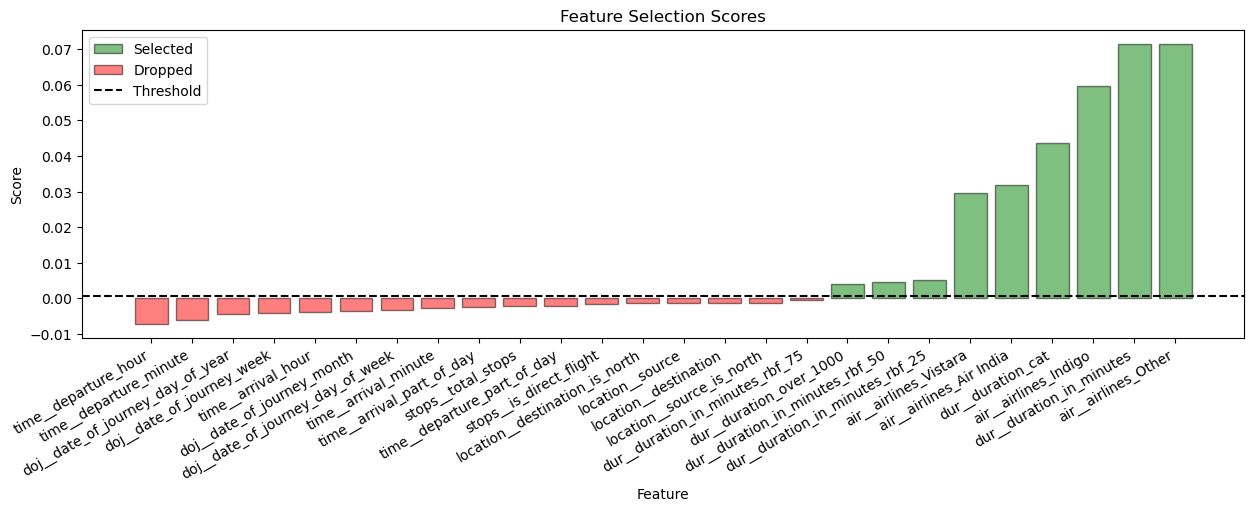

In [105]:
THRESHOLD = 0.0005

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.0005,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 26 columns after Feature Engineering
- The Feature Selection algorithm selected 9 features out of that.